In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
import mdtraj as md
from sklearn.pipeline import Pipeline
from msmbuilder.io import load_trajs, load_meta, preload_tops, load_generic
from msmbuilder.feature_extraction import DihedralFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
import numpy as np

## Load data

In [5]:
def get_timings(meta):
    frames_tot = meta['nframes'].sum()
    n_frames = meta['nframes'].unique()
    assert (len(n_frames) == 1, 'Different trajectory lengths')
    n_frames = n_frames[0]
    dt = meta['step_ps'][0]
    to_ns = dt/1000
    t_max = n_frames*to_ns
    return to_ns, t_max, frames_tot


def traj_load(irow):
    i, row = irow
    traj = md.load(row['traj_fn'], top=tops[row['top_fn']])
    return i, traj


<ipython-input-5-b7f0c528c48c>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(n_frames) == 1, 'Different trajectory lengths')


In [6]:
meta = load_meta('meta.pandas.pickl')
tops = preload_tops(meta)
trajs = [md.load(row['traj_fn'], top=tops[row['top_fn']], stride=1) 
         for i, row in meta.iterrows()]

## Get internal coordinates

In [7]:
bonds = load_generic('proc_traj/2agy_as-1_bonds.pickl')
angles = load_generic('proc_traj/2agy_as-1_angles.pickl')
dihedrals = load_generic('proc_traj/2agy_as-1_dihedrals.pickl')

## Set up the estimators for the pipeline



In [8]:
def compute_dihedrals(traj, indices):
    dihedrals = md.compute_dihedrals(traj, indices=indices)
    dihedrals = np.concatenate((np.cos(dihedrals), np.sin(dihedrals)), axis=1)
    return dihedrals

def compute_angles(traj, indices):
    angles = md.compute_angles(traj, angle_indices=indices)
    angles = np.concatenate((np.cos(angles), np.sin(angles)), axis=1)
    return angles



In [9]:
from msmbuilder.feature_extraction import FunctionFeaturizer, AtomPairsFeaturizer
from msmbuilder.feature_selection import FeatureSelector

dihedrals_feat = FunctionFeaturizer(compute_dihedrals, func_args={'indices': dihedrals})
angles_feat = FunctionFeaturizer(compute_angles, func_args={'indices': angles})
bonds_feat = AtomPairsFeaturizer(pair_indices=bonds, periodic=True)




## Project onto first reaction coordinate

In [10]:
features = FeatureSelector([('bonds', bonds_feat), ('angles', angles_feat), ('dihedrals', dihedrals_feat)], 
                         which_feat=['angles'])
ftrajs = features.fit_transform(trajs)

In [11]:
ftrajs[0].shape

(10000, 196)

In [12]:
to_ns, t_max, frames_tot = get_timings(meta)
estimators = [('variance', VarianceThreshold()),
              ('scaling', RobustScaler()), ('tICA', tICA())]
pipe = Pipeline(estimators)
pipe.set_params(tICA__lag_time=int(50/to_ns))
pipe.set_params(tICA__n_components=10)

# pipe.set_params(variance__threshold=0.5)

pipe.set_params(tICA__kinetic_mapping=True)

pipe.fit(ftrajs)



Pipeline(steps=[('variance', VarianceThreshold(threshold=0.0)), ('scaling', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('tICA', tICA(commute_mapping=False, kinetic_mapping=True, lag_time=5000,
   n_components=10, shrinkage=None))])

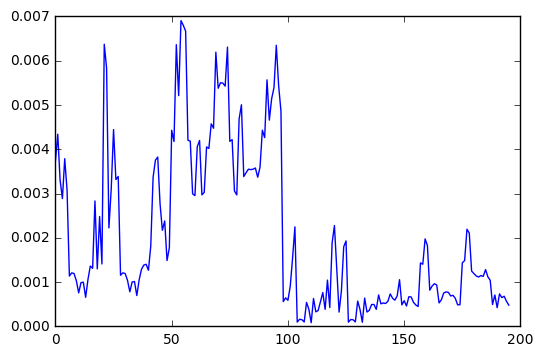

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(pipe.named_steps['variance'].variances_)

In [14]:
ttrajs = pipe.transform(ftrajs)

(10000,)


(-2, 2)

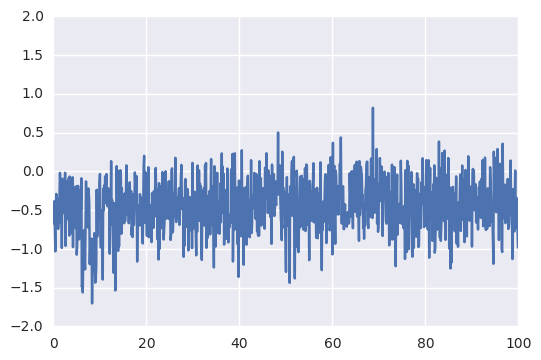

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
t = np.arange(ttrajs[0].shape[0])*to_ns
print(t.shape)
ax.plot(t[::10], ttrajs[18][::10,0])
ax.set_ylim((-2,2))

In [16]:
txx = np.concatenate(ttrajs)

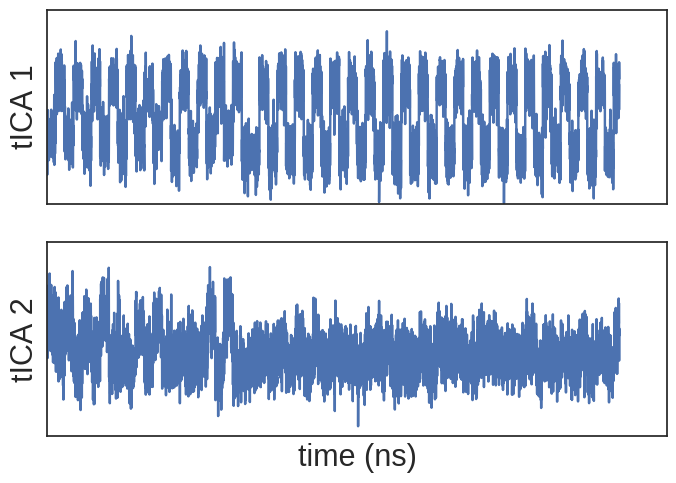

In [32]:
t = np.arange(txx.shape[0])*to_ns
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('white')
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(t[::100], txx[::100, 0])
    ax[0].set_ylabel('tICA 1')
    ax[0].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off', 
        left='off',
        labelbottom='off', 
        labelleft='off')
    
    ax[1].plot(t[::100], txx[::100, 1])
    ax[1].set_ylabel('tICA 2')
    ax[1].set_xlabel('time (ns)')
    ax[1].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off', 
        left='off',
        labelbottom='off', 
        labelleft='off')
plt.savefig('tICA_Trajectory.pdf')

In [18]:
pipe.named_steps['tICA'].timescales_*to_ns

array([ 242.22140068,   52.87036657,   33.45736741,   22.19962369,
         20.69177658,   18.94636843,   16.8415698 ,   16.23950863,
         15.81758619,   15.22514661])

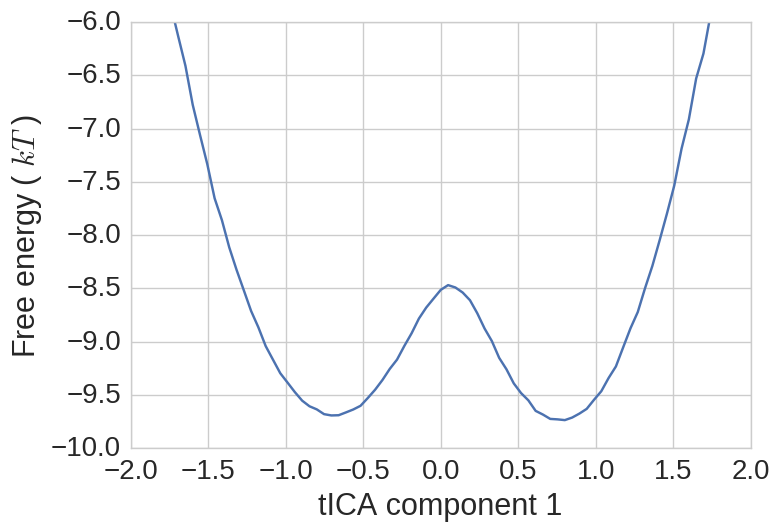

In [19]:
z,bins = np.histogram(txx[:,0],bins=100)

F = -np.log(z)
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    ax.plot(bins[1:], F)
    ax.set_xlim((-2,2))
    ax.set_ylim((-10,-6))

    ax.set_ylabel('Free energy ( $kT$ )')
    ax.set_xlabel('tICA component 1')
plt.savefig('tICA_FreeEnergy.pdf')

In [20]:
red_ttrajs = [ttraj[:,:2] for ttraj in ttrajs]
# red_ttrajs = [x[:, np.newaxis] for x in red_ttrajs]
print(len(red_ttrajs))
print(red_ttrajs[0].shape)

65
(10000, 2)


## Cluster

In [21]:
from msmbuilder.cluster import MiniBatchKMeans
cluster = MiniBatchKMeans(n_clusters=int(np.sqrt(frames_tot)))
ctrajs = cluster.fit_transform(red_ttrajs)

## Fit MSM

In [22]:
from msmbuilder.msm import MarkovStateModel
lags = np.linspace(int(20/to_ns), int(81/to_ns), 31)

tscales = np.zeros((lags.shape[0], 2))
for idx, lag in enumerate(lags):
    msm = MarkovStateModel(n_timescales=3, lag_time=lag)
    msm.fit(ctrajs)
    tscales[idx] = msm.timescales_[:2]


MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with popula

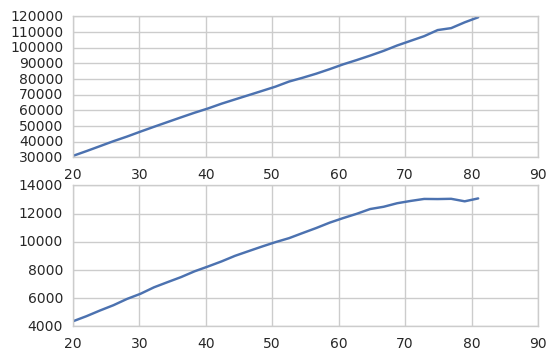

In [23]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(lags*to_ns, tscales.T[0])
ax[1].plot(lags*to_ns, tscales.T[1])

In [24]:
msm = MarkovStateModel(n_timescales=3, lag_time=int(70/to_ns))
msm.fit(ctrajs)

MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=7000, n_timescales=3,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

## Lump states using PCCA

In [82]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=3)
macro_trajs = pcca.transform(ctrajs, mode='fill')


Optimization terminated successfully.
         Current function value: -2.408761
         Iterations: 28
         Function evaluations: 83
(10000,)


(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(6208,)


-6.6528759325
4.60517018599


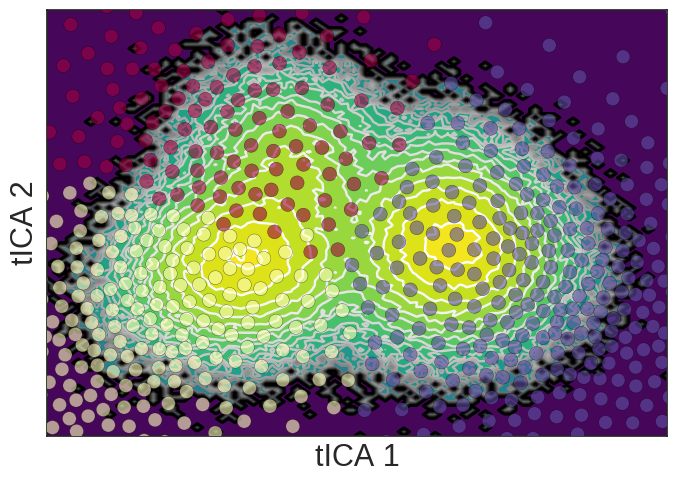

In [109]:
# histogram data
cols = sns.color_palette('colorblind', 3)
z,x,y = np.histogram2d(txx[:,0],txx[:,1], bins=100)
z = z+0.01
# compute free energies
F = -np.log(z)
# contour plot
print(F.min())
print(F.max())
extent = [-1, 1, -0.5, 1]
conts = 30
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('white')
    plt.contourf(F.T, conts, cmap='viridis_r', extent=extent)
    plt.contour(F.T, conts, extent=extent)

    plt.xlabel('tICA 1')
    plt.ylabel('tICA 2')
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off', 
        left='off',
        labelbottom='off', 
        labelleft='off')
# Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
plt.scatter(cluster.cluster_centers_[msm.state_labels_, 0],
            cluster.cluster_centers_[msm.state_labels_, 1],
            s=100,
            c=pcca.microstate_mapping_,
            zorder=3, alpha=0.6, cmap='Spectral'
           )
plt.xlim((-1,1))
plt.ylim((-0.5,1))

plt.savefig('FreeEnergy2D.pdf')

(-1, 3)

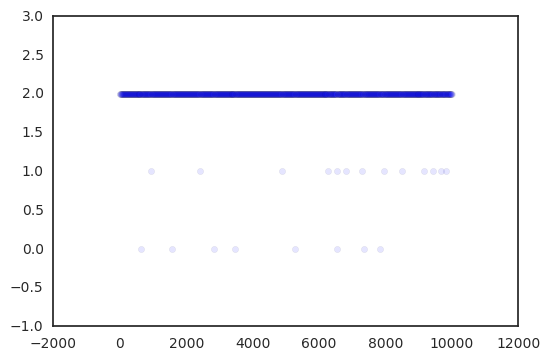

In [98]:
trajn = 1
plt.scatter(np.arange(macro_trajs[trajn].shape[0])[::10],macro_trajs[trajn][::10], alpha=0.1)
plt.ylim((-1,3))

In [95]:
meta.index[0]

('2agy', 1, 1)

In [112]:
traj_i=0
state=0
inds = np.where(macro_trajs[trajn]==state)[0]
sample_inds = np.random.choice(inds, 200)

traj = md.join(
    md.load_frame(meta.loc[meta.index[traj_i]]['traj_fn'], index=int(frame_i), top=meta.loc[meta.index[traj_i]]['top_fn'])
    for frame_i in sample_inds
)
traj.save("{}/{}.nc".format('trajectories', state))

10000
(640000,)
2
1
[ 398  523  746  837  846  950  973 1096 1129 1357]


array([ 394,  401,  405, ..., 9997, 9998, 9999])